# Single label Classifier - AF Detection

Using the dataset provided by the 2020 Physionet Challenge we've developed an Atrial Fibrilation Detector trained to identify AF diagnosed patients from a dataset containing patients with different pathologies like: PAC, RBBB, I-AVB, PVC, LBBB, STD, STE and healthy individuals.

Although data from 12-lead ECG was provided, for this first analysis we've only used the lead 2 data and we've processed the signals in order to create a dataframe consisting of features we believe will help us classify.


In [1]:
import sys
import os

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from IPython.display import display

from scipy.cluster import hierarchy as hc
from sklearn import metrics
from sklearn.metrics import f1_score, fbeta_score, make_scorer, confusion_matrix
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

import mlflow
import mlflow.sklearn

%matplotlib inline
import plotly.express as px
import seaborn as sns

## Load the Dataset

In [2]:
df_raw = pd.read_feather('datasets/phys-raw-lead2-HRV-eda')
df_raw.columns

Index(['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_CVNN', 'HRV_CVSD',
       'HRV_MedianNN', 'HRV_MadNN', 'HRV_MCVNN', 'HRV_IQRNN', 'HRV_pNN50',
       'HRV_pNN20', 'HRV_TINN', 'HRV_HTI', 'mean_P_Peaks', 'age', 'label'],
      dtype='object')

## Train test split

In [3]:
y = df_raw['label'].copy()
X = df_raw.drop('label', axis=1)
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42)

## Hyperparameter Tunning

In [4]:
params_RF = {
    'n_estimators': [10, 50, 200],
    'max_features': [1, 'sqrt', 'log2', 0.7]
}

params_SVC = {
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 0.1],
    'C': [1, 1.5, 1.7]
}

In [5]:
sc = make_scorer(f1_score, pos_label='AF')

In [6]:
res = pd.DataFrame({'model':[], 'f1 validation':[], 'f1 test':[]})

### Random Forest

In [7]:
rf = RandomForestClassifier(random_state=42)
rf_gs = GridSearchCV(rf, params_RF, cv=4, refit=True, scoring=sc, n_jobs=5)

%time rf_gs.fit(X_train, y_train)

ypred_rf = rf_gs.best_estimator_.predict(X_eval)
fi_test = f1_score(y_eval, ypred_rf, pos_label='AF')

res = res.append({'model': "RF", 'f1 validation': rf_gs.best_score_, 'f1 test': fi_test}, ignore_index=True)
rf_gs.best_params_

CPU times: user 2.29 s, sys: 64.7 ms, total: 2.36 s
Wall time: 17 s


{'max_features': 'sqrt', 'n_estimators': 200}

### SVC

In [8]:
scal = StandardScaler()
xtrain_scal = scal.fit_transform(X_train)
xeval_scal = scal.transform(X_eval)

In [9]:
svc = SVC(random_state=42)
svc_gs = GridSearchCV(svc, params_SVC, cv=4, refit=True, scoring=sc, n_jobs=5)

%time svc_gs.fit(xtrain_scal, y_train)

ypred_svc = svc_gs.best_estimator_.predict(xeval_scal)
f1_test = f1_score(y_eval, ypred_svc, pos_label='AF')

res = res.append({'model': "SVC", 'f1 validation': svc_gs.best_score_, 'f1 test': f1_test}, ignore_index=True)
svc_gs.best_params_

CPU times: user 506 ms, sys: 23.6 ms, total: 529 ms
Wall time: 2.77 s


{'C': 1.5, 'gamma': 'scale', 'kernel': 'rbf'}

In [10]:
res.sort_values('f1 validation', ascending=False)

,model,f1 validation,f1 test
0,Random Forest,0.901535,0.931646
1,SVC,0.894694,0.933673


## Confusion Matrix

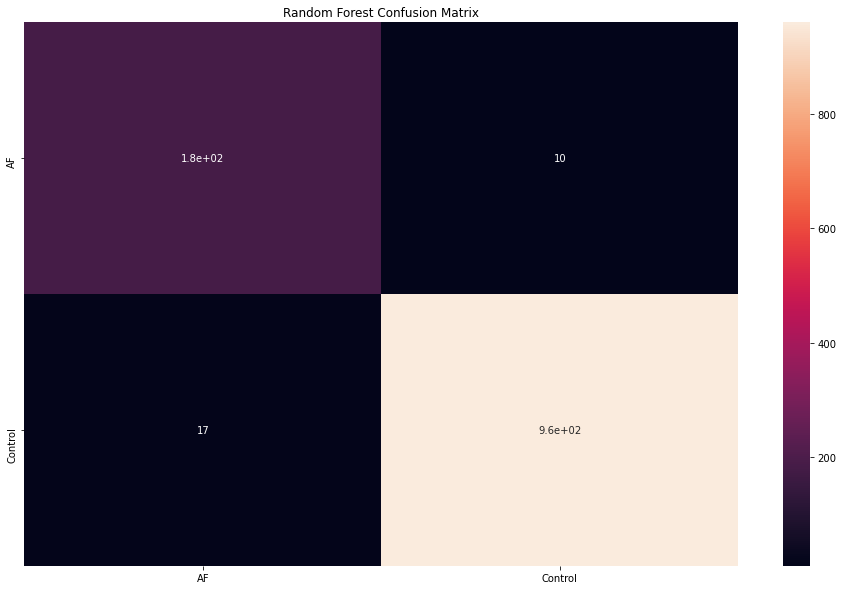

In [11]:
cm = confusion_matrix(y_eval, ypred_rf)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('Random Forest Confusion Matrix')
plt.show()

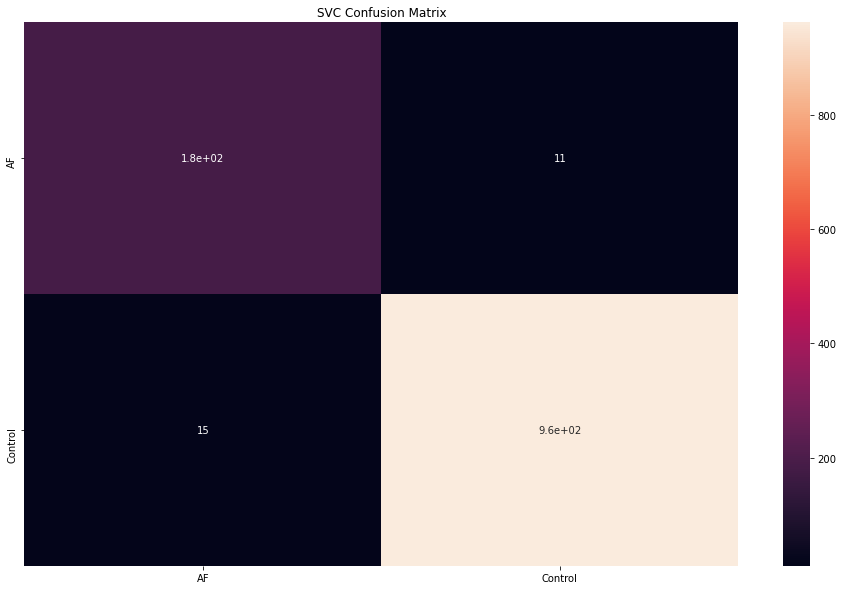

In [12]:
cm = confusion_matrix(y_eval, ypred_svc)

df_cm = pd.DataFrame(cm, index = ['AF', 'Control'], columns = ['AF', 'Control'])
plt.figure(figsize = (16,10))
sns.heatmap(df_cm, annot=True)
plt.title('SVC Confusion Matrix')
plt.show()